In [43]:
import sys
print(sys.executable)
print(sys.version)



c:\Users\santi\Documents\Hackathon\INDRA\.venv\Scripts\python.exe
3.12.10 (tags/v3.12.10:0cc8128, Apr  8 2025, 12:21:36) [MSC v.1943 64 bit (AMD64)]


In [ ]:
#1  

import pandas as pd
import numpy as np



IndentationError: unexpected indent (643863125.py, line 1)

In [ ]:
#2  
  
df = pd.read_csv("consumos_uptc Limpio completo.csv", sep=";")
df.columns = df.columns.str.strip()
print(df.shape)
df.head(3)


(275387, 26)


,reading_id,timestamp,sede,sede_id,energia_total_kwh,energia_comedor_kwh,energia_salones_kwh,energia_laboratorios_kwh,energia_auditorios_kwh,energia_oficinas_kwh,...,dia_nombre,mes,trimestre,ano,periodo_academico,es_fin_semana,es_festivo,es_semana_parciales,es_semana_finales,co2_kg
0,1,1/01/2018 0:00,Chiquinquira,UPTC_CHI,0.928,0.0452,0.1497,0.4334,0.0386,0.2613,...,Lunes,1,1,2018,vacaciones_fin,False,True,False,False,0.1877
1,2,1/01/2018 0:00,Duitama,UPTC_DUI,2.592,0.1129,0.2007,1.7993,0.0573,0.4217,...,Lunes,1,1,2018,vacaciones_fin,False,True,False,False,0.4490
2,3,1/01/2018 0:00,Sogamoso,UPTC_SOG,2.841,0.1395,0.2388,1.9638,NaN,0.4443,...,Lunes,1,1,2018,vacaciones_fin,False,True,False,False,0.6048


In [ ]:
#3  
  
df["timestamp"] = pd.to_datetime(df["timestamp"], dayfirst=True, format="mixed")
df = df.sort_values(["sede_id", "timestamp"]).reset_index(drop=True)

print("Rango:", df["timestamp"].min(), "→", df["timestamp"].max())
print("NaT timestamp:", df["timestamp"].isna().sum())


Rango: 2018-01-01 00:00:00 → 2025-10-31 00:00:00
NaT timestamp: 0


In [ ]:
#4  
  
num_cols = [
    "energia_total_kwh",
    "energia_comedor_kwh","energia_salones_kwh","energia_laboratorios_kwh",
    "energia_auditorios_kwh","energia_oficinas_kwh",
    "potencia_total_kw","agua_litros","temperatura_exterior_c","ocupacion_pct","co2_kg"
]

for c in num_cols:
    if c in df.columns:
        df[c] = pd.to_numeric(df[c], errors="coerce")

print("NaN por columna (top):")
print(df[num_cols].isna().sum().sort_values(ascending=False).head(10))

print("\nDtypes:")
print(df[num_cols].dtypes)


NaN por columna (top):
ocupacion_pct               32766
temperatura_exterior_c      16385
co2_kg                      13796
energia_auditorios_kwh      13618
agua_litros                 10982
energia_comedor_kwh          8254
energia_total_kwh               0
energia_salones_kwh             0
potencia_total_kw               0
energia_laboratorios_kwh        0
dtype: int64

Dtypes:
energia_total_kwh           float64
energia_comedor_kwh         float64
energia_salones_kwh         float64
energia_laboratorios_kwh    float64
energia_auditorios_kwh      float64
energia_oficinas_kwh        float64
potencia_total_kw           float64
agua_litros                 float64
temperatura_exterior_c      float64
ocupacion_pct               float64
co2_kg                      float64
dtype: object


In [ ]:
#5  
  
ts = df["timestamp"]
df["hour"] = ts.dt.hour
df["dayofweek"] = ts.dt.dayofweek
df["month"] = ts.dt.month

df["hour_sin"] = np.sin(2*np.pi*df["hour"]/24)
df["hour_cos"] = np.cos(2*np.pi*df["hour"]/24)
df["dow_sin"]  = np.sin(2*np.pi*df["dayofweek"]/7)
df["dow_cos"]  = np.cos(2*np.pi*df["dayofweek"]/7)


In [ ]:
#6  
  
sector_cols = [
    "energia_comedor_kwh",
    "energia_salones_kwh",
    "energia_laboratorios_kwh",
    "energia_auditorios_kwh",
    "energia_oficinas_kwh"
]

df_long = df.melt(
    id_vars=[c for c in df.columns if c not in sector_cols],
    value_vars=sector_cols,
    var_name="sector",
    value_name="kwh"
)

df_long["sector"] = (
    df_long["sector"]
    .str.replace("energia_", "", regex=False)
    .str.replace("_kwh", "", regex=False)
)

df_long = df_long.sort_values(["sede_id","sector","timestamp"]).reset_index(drop=True)

print("Shape df_long:", df_long.shape)
df_long[["timestamp","sede_id","sector","kwh"]].head(10)


Shape df_long: (1376935, 30)


,timestamp,sede_id,sector,kwh
0,2018-01-30 07:00:00,UPTC-CHI,auditorios,0.0408
1,2018-02-23 16:00:00,UPTC-CHI,auditorios,0.0447
2,2018-05-17 13:00:00,UPTC-CHI,auditorios,0.0498
3,2018-05-20 09:00:00,UPTC-CHI,auditorios,0.0480
4,2018-05-27 09:00:00,UPTC-CHI,auditorios,0.0507
5,2018-06-23 10:00:00,UPTC-CHI,auditorios,0.0529
6,2018-07-31 23:00:00,UPTC-CHI,auditorios,0.0523
7,2018-08-26 02:00:00,UPTC-CHI,auditorios,0.0536
8,2018-09-22 16:00:00,UPTC-CHI,auditorios,0.0475
9,2019-07-07 03:00:00,UPTC-CHI,auditorios,0.0623


In [ ]:
#7  
  
df_long["kwh"] = pd.to_numeric(df_long["kwh"], errors="coerce")
df_long = df_long.dropna(subset=["kwh"]).copy()
g = df_long.groupby(["sede_id", "sector"])

df_long["lag_1"]   = g["kwh"].shift(1)
df_long["lag_24"]  = g["kwh"].shift(24)
df_long["lag_168"] = g["kwh"].shift(168)

df_long["roll_24_mean"] = g["kwh"].transform(lambda s: s.shift(1).rolling(24).mean())
df_long["roll_168_mean"] = g["kwh"].transform(lambda s: s.shift(1).rolling(168).mean())

df_model = df_long.dropna().copy()
print("Shape df_model:", df_model.shape)



Shape df_model: (1020462, 35)


In [ ]:
#8  
  
features = [
    "hour_sin","hour_cos","dow_sin","dow_cos","month",
    "lag_1","lag_24","lag_168","roll_24_mean","roll_168_mean",
    "temperatura_exterior_c","ocupacion_pct",
    "es_fin_semana","es_festivo","es_semana_parciales","es_semana_finales",
    "sector","sede_id"
]

# dejar solo las que existan
features = [c for c in features if c in df_model.columns]

cat_features = [c for c in ["sector","sede_id","periodo_academico","dia_nombre","sede"] if c in df_model.columns]

print("Features:", features)
print("Cat features:", cat_features)


Features: ['hour_sin', 'hour_cos', 'dow_sin', 'dow_cos', 'month', 'lag_1', 'lag_24', 'lag_168', 'roll_24_mean', 'roll_168_mean', 'temperatura_exterior_c', 'ocupacion_pct', 'es_fin_semana', 'es_festivo', 'es_semana_parciales', 'es_semana_finales', 'sector', 'sede_id']
Cat features: ['sector', 'sede_id', 'periodo_academico', 'dia_nombre', 'sede']


In [ ]:
#9  
  
cutoff = df_model["timestamp"].quantile(0.8)

train = df_model[df_model["timestamp"] <= cutoff].copy()
test  = df_model[df_model["timestamp"] > cutoff].copy()

X_train, y_train = train[features], train["kwh"]
X_test,  y_test  = test[features],  test["kwh"]

print("Train:", train.shape, "Test:", test.shape)


Train: (816376, 35) Test: (204086, 35)


In [ ]:
#10  
  
# 1) asegurar que cat_features exista en features
cat_features = [c for c in cat_features if c in features]

# 2) asegurar que cat_features exista en X_train
cat_features = [c for c in cat_features if c in X_train.columns]

print("Cat features finales:", cat_features)


Cat features finales: ['sector', 'sede_id']


In [ ]:
#11  
  
from catboost import CatBoostRegressor

model = CatBoostRegressor(
    loss_function="RMSE",
    iterations=800,
    learning_rate=0.05,
    depth=8,
    random_seed=42,
    verbose=200
)


In [ ]:
#12  
  
#model = CatBoostRegressor(
#    loss_function="RMSE",
#    iterations=5000,
#    learning_rate=0.05,
#    depth=8,
#    random_seed=42,
#    verbose=200
#)

#model.fit(
#    X_train, y_train,
#    cat_features=cat_idx,
#    eval_set=(X_test, y_test),
#    use_best_model=True,
#    early_stopping_rounds=200
#)


0:	learn: 1.4640126	test: 1.8601884	best: 1.8601884 (0)	total: 161ms	remaining: 13m 24s
200:	learn: 0.3320040	test: 0.4191169	best: 0.4191169 (200)	total: 28.8s	remaining: 11m 27s
400:	learn: 0.3102839	test: 0.3964599	best: 0.3964599 (400)	total: 56.5s	remaining: 10m 48s
600:	learn: 0.3005041	test: 0.3888076	best: 0.3888076 (600)	total: 1m 24s	remaining: 10m 20s
800:	learn: 0.2935848	test: 0.3852506	best: 0.3852506 (800)	total: 1m 52s	remaining: 9m 47s
1000:	learn: 0.2880326	test: 0.3826574	best: 0.3826418 (999)	total: 2m 19s	remaining: 9m 18s
1200:	learn: 0.2834876	test: 0.3809277	best: 0.3809277 (1200)	total: 2m 47s	remaining: 8m 49s
1400:	learn: 0.2792774	test: 0.3800069	best: 0.3799949 (1396)	total: 3m 15s	remaining: 8m 23s
1600:	learn: 0.2752095	test: 0.3792641	best: 0.3792641 (1600)	total: 3m 43s	remaining: 7m 55s
1800:	learn: 0.2713365	test: 0.3783755	best: 0.3783755 (1800)	total: 4m 12s	remaining: 7m 28s
2000:	learn: 0.2681488	test: 0.3780298	best: 0.3780049 (1981)	total: 4m 40

In [ ]:
#13  
  
cat_idx = [X_train.columns.get_loc(c) for c in cat_features] if cat_features else None
model.fit(X_train, y_train, cat_features=cat_idx)


0:	learn: 1.4640126	total: 150ms	remaining: 2m
200:	learn: 0.3320040	total: 27.8s	remaining: 1m 22s
400:	learn: 0.3102839	total: 54.1s	remaining: 53.8s
600:	learn: 0.3005041	total: 1m 20s	remaining: 26.7s
799:	learn: 0.2936238	total: 1m 47s	remaining: 0us


In [ ]:
#14  
  
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error

pred = model.predict(X_test)

mae = mean_absolute_error(y_test, pred)
mse = mean_squared_error(y_test, pred)   # sin squared
rmse = np.sqrt(mse)

print("MAE:", mae)
print("RMSE:", rmse)



MAE: 0.1398699692440358
RMSE: 0.3852876906500727


In [ ]:
#15  
  
print("Mean y_test:", float(y_test.mean()))
print("RMSE/Mean:", float(rmse / y_test.mean()))


Mean y_test: 1.3231967506004283
RMSE/Mean: 0.29117944136065954


In [ ]:
#16  
  
print("Mean y_test:", float(y_test.mean()))
print("RMSE/Mean:", float(rmse / y_test.mean()))


Mean y_test: 1.3231967506004283
RMSE/Mean: 0.29117944136065954


In [ ]:
#17  
  
import numpy as np
import pandas as pd


test_eval = test[["timestamp","sede_id","sector","kwh"]].copy()
test_eval["pred"] = pred
test_eval["abs_err"] = (test_eval["kwh"] - test_eval["pred"]).abs()
test_eval["sq_err"]  = (test_eval["kwh"] - test_eval["pred"])**2


sector_metrics = (
    test_eval.groupby("sector")
    .agg(
        mae=("abs_err","mean"),
        rmse=("sq_err", lambda s: float(np.sqrt(s.mean()))),
        n=("kwh","size"),
        mean_kwh=("kwh","mean")
    )
    .sort_values("rmse", ascending=False)
)

print("=== Métricas por sector ===")
display(sector_metrics)


sede_metrics = (
    test_eval.groupby("sede_id")
    .agg(
        mae=("abs_err","mean"),
        rmse=("sq_err", lambda s: float(np.sqrt(s.mean()))),
        n=("kwh","size"),
        mean_kwh=("kwh","mean")
    )
    .sort_values("rmse", ascending=False)
)

print("=== Métricas por sede ===")
display(sede_metrics)



sede_sector_metrics = (
    test_eval.groupby(["sede_id","sector"])
    .agg(
        mae=("abs_err","mean"),
        rmse=("sq_err", lambda s: float(np.sqrt(s.mean()))),
        n=("kwh","size"),
        mean_kwh=("kwh","mean")
    )
    .reset_index()
    .sort_values("rmse", ascending=False)
)

print("=== Top 20 sede-sector con mayor RMSE ===")
display(sede_sector_metrics.head(20))


pivot_rmse = sede_sector_metrics.pivot(index="sede_id", columns="sector", values="rmse")

print("=== Matriz RMSE (sede x sector) ===")
display(pivot_rmse)
  
  
##Esta matriz muestra el RMSE del modelo por combinación sede–sector, permitiendo priorizar dónde el desempeño predictivo es menor y dónde conviene enfocar auditoría/análisis de eficiencia energética

=== Métricas por sector ===


,mae,rmse,n,mean_kwh
sector,,,,
laboratorios,0.253205,0.711463,41487,3.129628
oficinas,0.153891,0.275968,41487,1.574169
salones,0.128645,0.271145,41487,1.286551
auditorios,0.104810,0.260237,39449,0.138863
comedor,0.054374,0.101597,40176,0.399402


=== Métricas por sede ===


,mae,rmse,n,mean_kwh
sede_id,,,,
UPTC_SOG,0.191644,0.508073,51214,1.926452
UPTC_DUI,0.191449,0.500211,50886,1.865178
UPTC_TUN,0.096671,0.239214,50954,0.868704
UPTC_CHI,0.079612,0.167254,51032,0.631158


=== Top 20 sede-sector con mayor RMSE ===


,sede_id,sector,mae,rmse,n,mean_kwh
12,UPTC_SOG,laboratorios,0.392975,0.974859,10407,5.011599
7,UPTC_DUI,laboratorios,0.358927,0.926532,10346,4.562510
17,UPTC_TUN,laboratorios,0.172041,0.428941,10357,2.027923
9,UPTC_DUI,salones,0.172515,0.354255,10346,1.794850
8,UPTC_DUI,oficinas,0.201211,0.347623,10346,2.102722
13,UPTC_SOG,oficinas,0.200934,0.342584,10407,2.109587
5,UPTC_DUI,auditorios,0.143437,0.339015,9827,0.187224
14,UPTC_SOG,salones,0.160918,0.324418,10407,1.672882
10,UPTC_SOG,auditorios,0.123076,0.290788,9920,0.160068
4,UPTC_CHI,salones,0.099321,0.196880,10377,0.915233


=== Matriz RMSE (sede x sector) ===


sector,auditorios,comedor,laboratorios,oficinas,salones
sede_id,,,,,
UPTC_CHI,0.195282,0.043531,0.176243,0.172334,0.196880
UPTC_DUI,0.339015,0.131233,0.926532,0.347623,0.354255
UPTC_SOG,0.290788,0.131612,0.974859,0.342584,0.324418
UPTC_TUN,0.182390,0.069587,0.428941,0.191489,0.156663


In [ ]:
#18  
  
import numpy as np
import pandas as pd

def make_time_features(ts_series):
    hour = ts_series.dt.hour
    dow = ts_series.dt.dayofweek
    month = ts_series.dt.month

    out = pd.DataFrame({
        "month": month,
        "hour_sin": np.sin(2*np.pi*hour/24),
        "hour_cos": np.cos(2*np.pi*hour/24),
        "dow_sin":  np.sin(2*np.pi*dow/7),
        "dow_cos":  np.cos(2*np.pi*dow/7),
    })
    return out

def forecast_autoreg(df_model, model, features, cat_features, horizon_hours=168, min_history=200):
    """
    Forecast autoregresivo por sede_id + sector.
    - Usa historia real (kwh) + predicciones previas para construir lags/rolling.
    - Genera horizonte futuro en horas (168 = 7 días).
    - Guarda predicciones en un dataframe.
    """
    df_hist = df_model[["timestamp","sede_id","sector","kwh"]].copy()
    df_hist = df_hist.sort_values(["sede_id","sector","timestamp"]).reset_index(drop=True)

    preds_all = []

    for (sede_id, sector), g in df_hist.groupby(["sede_id","sector"]):
        g = g.sort_values("timestamp").reset_index(drop=True)

        # asegurar historia mínima para lag_168 y rolling_168
        if len(g) < min_history:
            continue

        last_ts = g["timestamp"].iloc[-1]

        # historia extendida (incluye predicciones a medida que avanzamos)
        kwh_series = g["kwh"].astype(float).tolist()

        for h in range(1, horizon_hours+1):
            ts_next = last_ts + pd.Timedelta(hours=h)

            row = {
                "timestamp": ts_next,
                "sede_id": sede_id,
                "sector": sector,
            }

            # features temporales
            tmp = make_time_features(pd.Series([ts_next]))
            row.update(tmp.iloc[0].to_dict())

            # flags calendario: por defecto 0 (supuesto simple)
            for flag in ["es_fin_semana","es_festivo","es_semana_parciales","es_semana_finales"]:
                if flag in features:
                    row[flag] = 0

            # exógenas: si están en features, dejamos NaN (CatBoost tolera)
            for ex in ["temperatura_exterior_c","ocupacion_pct","agua_litros","co2_kg","potencia_total_kw"]:
                if ex in features:
                    row[ex] = np.nan

            # helpers lags
            def safe_get(idx_from_end):
                if len(kwh_series) >= idx_from_end:
                    return kwh_series[-idx_from_end]
                return np.nan

            # lags y rolling (autoregresivo)
            if "lag_1" in features:
                row["lag_1"] = safe_get(1)
            if "lag_24" in features:
                row["lag_24"] = safe_get(24)
            if "lag_168" in features:
                row["lag_168"] = safe_get(168)

            if "roll_24_mean" in features:
                row["roll_24_mean"] = float(np.mean(kwh_series[-24:])) if len(kwh_series) >= 24 else np.nan
            if "roll_168_mean" in features:
                row["roll_168_mean"] = float(np.mean(kwh_series[-168:])) if len(kwh_series) >= 168 else np.nan

            # construir X con el orden exacto de features
            X_next = pd.DataFrame([{c: row.get(c, np.nan) for c in features}])

            # índices categóricas
            cat_idx = [X_next.columns.get_loc(c) for c in cat_features] if cat_features else None

            # predecir
            y_next = float(model.predict(X_next)[0])

            preds_all.append({
                "timestamp": ts_next,
                "sede_id": sede_id,
                "sector": sector,
                "pred_kwh": y_next
            })

            # agregar predicción a la historia para el siguiente paso
            kwh_series.append(y_next)

    return pd.DataFrame(preds_all)

# ======= EJECUCIÓN: 7 días (168 horas) =======
horizon_hours = 168
future_preds = forecast_autoreg(
    df_model=df_model,
    model=model,
    features=features,
    cat_features=cat_features,
    horizon_hours=horizon_hours,
    min_history=200
)

future_preds = future_preds.sort_values(["sede_id","sector","timestamp"]).reset_index(drop=True)

print("Forecast rows:", future_preds.shape)  # esperado: 20 * 168 = 3360 filas
print("N combinaciones sede-sector:", future_preds[["sede_id","sector"]].drop_duplicates().shape[0])

# Guardar CSV
output_path = "forecast_7dias_sede_sector.csv"
future_preds.to_csv(output_path, index=False, encoding="utf-8-sig")
print("CSV guardado en:", output_path)

future_preds.head(10)


Forecast rows: (3360, 4)
N combinaciones sede-sector: 20
CSV guardado en: forecast_7dias_sede_sector.csv


,timestamp,sede_id,sector,pred_kwh
0,2025-10-31 01:00:00,UPTC_CHI,auditorios,0.070842
1,2025-10-31 02:00:00,UPTC_CHI,auditorios,0.073727
2,2025-10-31 03:00:00,UPTC_CHI,auditorios,0.073424
3,2025-10-31 04:00:00,UPTC_CHI,auditorios,0.078426
4,2025-10-31 05:00:00,UPTC_CHI,auditorios,0.070766
5,2025-10-31 06:00:00,UPTC_CHI,auditorios,0.075705
6,2025-10-31 07:00:00,UPTC_CHI,auditorios,0.068918
7,2025-10-31 08:00:00,UPTC_CHI,auditorios,0.085289
8,2025-10-31 09:00:00,UPTC_CHI,auditorios,0.075892
9,2025-10-31 10:00:00,UPTC_CHI,auditorios,0.078748


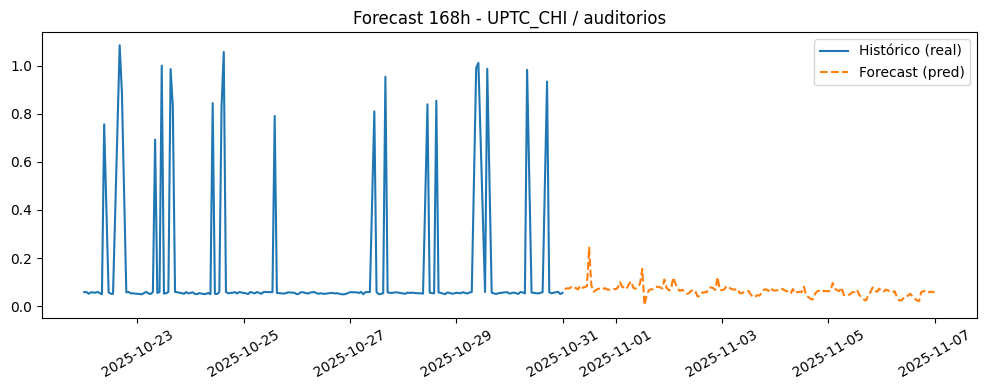

In [ ]:
#19
  
import matplotlib.pyplot as plt

# Elige una sede y sector para demo
demo_sede = future_preds["sede_id"].iloc[0]
demo_sector = future_preds["sector"].iloc[0]

hist_demo = df_model[(df_model["sede_id"] == demo_sede) & (df_model["sector"] == demo_sector)].copy()
hist_demo = hist_demo.sort_values("timestamp").tail(24*7)  # última semana

fut_demo = future_preds[(future_preds["sede_id"] == demo_sede) & (future_preds["sector"] == demo_sector)].copy()
fut_demo = fut_demo.sort_values("timestamp")

plt.figure(figsize=(10,4))
plt.plot(hist_demo["timestamp"], hist_demo["kwh"], label="Histórico (real)")
plt.plot(fut_demo["timestamp"], fut_demo["pred_kwh"], label="Forecast (pred)", linestyle="--")
plt.xticks(rotation=30)
plt.title(f"Forecast {horizon_hours}h - {demo_sede} / {demo_sector}")
plt.legend()
plt.tight_layout()
plt.show()
